# Poisson Pressure Solver

Let $(x,y,z)\in[x_{\text{min}}, x_{\text{max}}]\times[y_{\text{min}}, y_{\text{max}}]\times[z_{\text{min}}, z_{\text{max}}]=[0, 2\pi]^3=\Omega$, 
then the Poisson's problem is defined as
\begin{equation}
    \begin{split}
        \nabla^2p(x,y,z) &= \left(\dfrac{\partial^2}{\partial x^2} + \dfrac{\partial^2}{\partial y^2} + \dfrac{\partial^2}{\partial z^2}\right)p(x,y,z) 
            = f(x,y,z) \quad \text{in} ~ \Omega,\\
        \frac{\partial p}{\partial z} &=0, \quad \text{on} ~ z=z_{\text{min}}, \\
        p &= 0, \quad \text{on} ~ z=z_{\text{max}},
    \end{split}
\end{equation}

with periodic boundary conditions in $x$ and $y$ directions, and

\begin{equation}
    f(x,y,z) = \frac{1}{\pi^3}
        \left[
            \left(z^3-2\pi z^2\right)
            \left(
            \dfrac{2}{s_x}\left(1-\dfrac{2}{s_x}(x-x_0)^2\right) + 
            \dfrac{2}{s_y}\left(1-\dfrac{2}{s_y}(y-y_0)^2\right)
            \right) 
            + g(z)
        \right]
        G(x,y,z),
\end{equation}

with

\begin{equation*}
    G(x,y,z)=\exp\left(-\left(\frac{(x - x_0)^2}{s_x} + \frac{(y - y_0)^2}{s_y}+ \frac{(z - z_0)^2}{s_z}\right)\right),
\end{equation*}

and

\begin{equation*}
    g(z) =\dfrac{2}{s_z}z^5-\left(\dfrac{4\pi  + 4z_0}{s_z}\right)z^4 + 
        \left(\dfrac{8\pi z_0 + 2z_0^2-3s_z+8}{s_z}\right)z^3 
        + \left(\dfrac{4\pi s_z - 4\pi z_0^2+3s_zz_0-12\pi+6z_0}{s_z}\right)z^2
        + \left(\dfrac{8\pi z_0-6s_z+4\pi z_0s_z}{s_z}\right)z + 4\pi
\end{equation*}

The solution of this problem is
\begin{equation}
    p(x,y,z) = \frac{1}{\pi^3}(2\pi z^2-z^3)\,G(x,y,z).
\end{equation}

We use $x_0=y_0=z_0=\pi$, and $s_x=s_y=s_z=.5$.

In [1]:
from fftfd import *

In [2]:
x0 = y0 = z0 = np.pi 
sx = sy = sz = .5

In [11]:
# Functions
G = lambda x, y, z: np.exp(-((x - x0) ** 2 / sx + (y - y0) ** 2 / sy + (z - z0) ** 2 / sz))
g = lambda z: 2 * z ** 5 / sz - (4 * np.pi + 4 * z0) * z ** 4 / sz + (8 * np.pi * z0 + 2 * z0 ** 2 - 3 * sz + 8) * z ** 3 / sz + \
    (4 * np.pi * sz - 4 * np.pi * z0 ** 2 + 3 * sz * z0 - 12 * np.pi + 6 * z0) * z ** 2 / sz + (8 * np.pi * z0 - 6 * sz + 4 * np.pi * z0 * sz) / sz * z + 4 * np.pi
p = lambda x, y, z: (2 * np.pi * z ** 2 - z ** 3) * G(x, y, z) / np.pi ** 3
f = lambda x, y, z: ((z ** 3 - 2 * np.pi * z ** 2) * (2 * (1 - 2 * (x - x0) ** 2 / sx) / sx + 2 * (1 - 2 * (y - y0) ** 2 / sy) / sy) + g(z)) * G(x, y, z) / np.pi ** 3
pz = lambda x, y, z: ((4 * np.pi * z - 3 * z ** 2) - 2 / sz * (z - z0) * (2 * np.pi * z ** 2 - z ** 3)) * G(x, y, z) / np.pi ** 3
log_abs = lambda p, pa: np.log(np.abs(p - pa) + 1e-16)

In [12]:
Nx, Ny, Nz = 32, 32, 32
x = np.linspace(0, 2 * np.pi, Nx)
y = np.linspace(0, 2 * np.pi, Ny)
z = np.linspace(0, 2 * np.pi, Nz)
dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1] - z[0]
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

In [13]:
P = p(X, Y, Z)
F = f(X, Y, Z)
pxx = np.diff(P, 2, axis=0) / dx ** 2
pyy = np.diff(P, 2, axis=1) / dy ** 2
pzz = np.diff(P, 2, axis=2) / dz ** 2
lap_p = pxx[:, 1:-1, 1:-1] + pyy[1:-1, :, 1:-1] + pzz[1:-1, 1:-1, :]

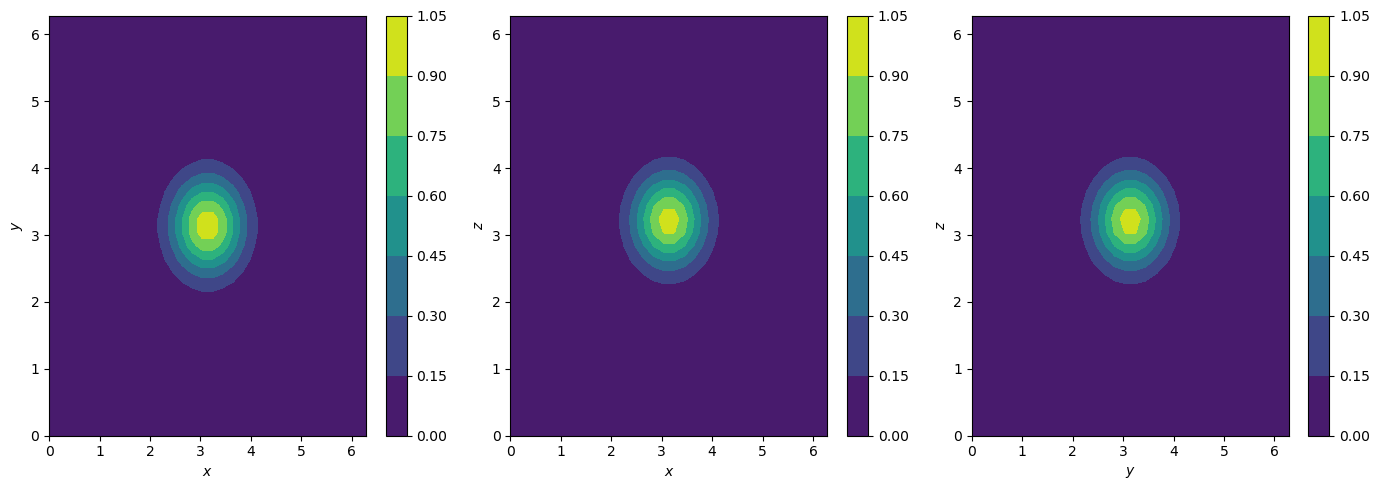

In [17]:
plot(x, y, z, P)

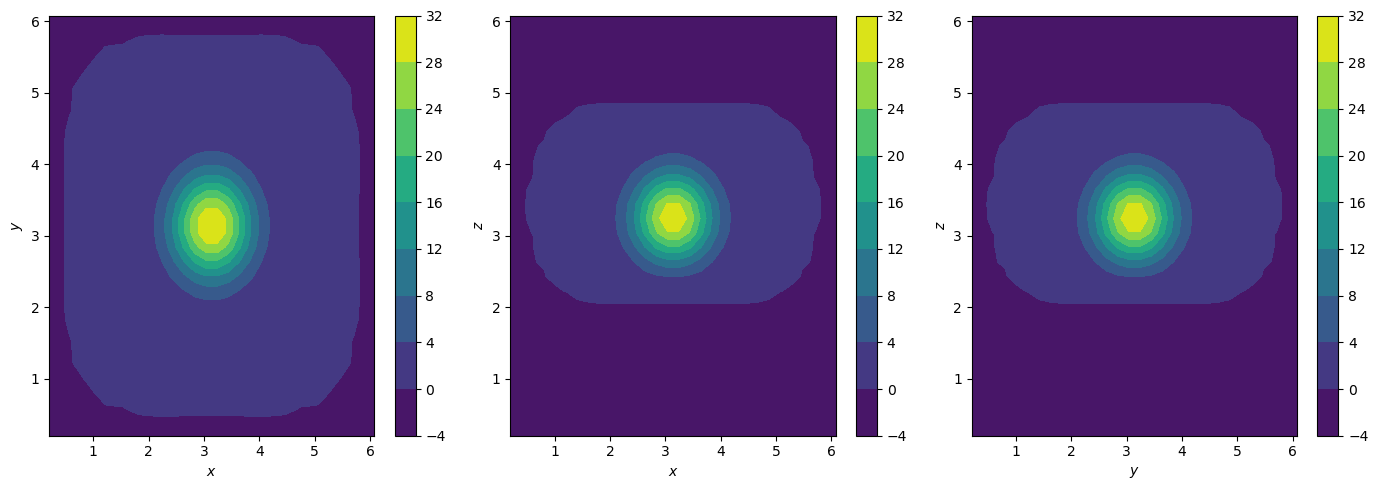

In [15]:
plot(x[1:-1], y[1:-1], z[1:-1], F[1:-1, 1:-1, 1:-1]- lap_p)

### Analytic verification

In [9]:
# Variables
x_sym, y_sym = sym.symbols('x y')
# Domain
x_min, x_max = 0, 2 * np.pi
y_min, y_max = 0, 2 * np.pi
# Parameters of solution
x_0, y0 = (x_max + x_min) / 2, (y_max + y_min) / 2
sx, sy = .5, .5
# Solution
#p_sym = sym.exp(-((x_sym - x_0) ** 2 / sx + (y_sym - y_0) ** 2 / sy))
p_sym = (2 * np.pi * y_sym ** 2 - y_sym ** 3) * sym.exp(-((x_sym - x_0) ** 2 / sx + (y_sym - y0) ** 2 / sy)) / (np.pi ** 3)
# Partial derivatives
px_sym = sym.diff(p_sym, x_sym) #px
pxx_sym = sym.diff(p_sym, x_sym, 2) # pxx
py_sym = sym.diff(p_sym, y_sym) # py
pyy_sym = sym.diff(p_sym, y_sym, 2) # pyy
# Functions to evaluate
pyl = sym.lambdify([x_sym, y_sym], py_sym, 'numpy') # py 
pl = sym.lambdify([x_sym, y_sym], p_sym, 'numpy') # p
f_sym = pxx_sym + pyy_sym
fl_sym = sym.lambdify([x_sym, y_sym], f_sym, 'numpy') # f
f_sym

-y**2*(0.0322515344331995*y - 0.202642367284676)*(157.91367041743*(0.318309886183791*x - 1)**2 - 4.0)*exp(-19.7392088021787*(0.318309886183791*x - 1)**2 - 19.7392088021787*(0.318309886183791*y - 1)**2) + (-y**2*(0.0322515344331995*y - 0.202642367284676)*(157.91367041743*(0.318309886183791*y - 1)**2 - 4.0) + 2*y*(0.0967546032995985*y - 0.405284734569351)*(4.0*y - 12.5663706143592) - 0.193509206599197*y + 0.405284734569351)*exp(-19.7392088021787*(0.318309886183791*x - 1)**2 - 19.7392088021787*(0.318309886183791*y - 1)**2)

## Numerics

\begin{equation}
    \begin{split}
        \frac{\partial p}{\partial y} &= \frac{1}{\pi^3}\left[
            (4\pi y-3y^2)\exp\left(-\left(\frac{(x - x_0)^2}{s_x} + \frac{(y - y_0)^2}{s_y}\right)\right) - 
            \frac{2}{s_y}(y-y_0)(2\pi y^2-y^3)\exp\left(-\left(\frac{(x - x_0)^2}{s_x} + \frac{(y - y_0)^2}{s_y}\right)\right)
        \right] \\
        &= \frac{1}{\pi^3}\left[
            \left((4\pi y-3y^2) - \frac{2}{s_y}(y-y_0)(2\pi y^2-y^3)\right)
            \exp\left(-\left(\frac{(x - x_0)^2}{s_x} + \frac{(y - y_0)^2}{s_y}\right)\right)
        \right]
    \end{split}
\end{equation}

In [10]:
# Analytic solution
G = lambda x, y: np.exp(-((x - x_0) ** 2 / sx + (y - y0) ** 2 / sy)) 
p = lambda x, y: (2 * np.pi * y ** 2 - y ** 3) * G(x, y) / (np.pi ** 3)
r = lambda y: (4 * np.pi - 6 * y) - 2 / sy * ((2 * np.pi * y ** 2 - y ** 3) + (y - y0) * (4 * np.pi * y - 3 * y ** 2)) - \
    2 / sy * (y - y0) * ((4 * np.pi * y - 3 * y ** 2) - 2 / sy * (y - y0) * (2 * np.pi * y ** 2 - y ** 3))
py = lambda x, y: ((4 * np.pi * y - 3 * y ** 2) - 2 / sy * (y - y0) * (2 * np.pi * y ** 2 - y ** 3)) * G(x, y) / np.pi ** 3
pxx = lambda x, y: -2 / (sx * np.pi ** 3) * (2 * np.pi * y ** 2 - y ** 3) * (1 - 2 / sx * (x - x_0) ** 2) * G(x, y)
pyy = lambda x, y: r(y) * G (x, y) / np.pi ** 3
f = lambda x, y: pxx(x, y) + pyy(x, y)
log_abs = lambda p, pa: np.log(np.abs(p - pa) + 1e-16)

In [11]:
Nx, Ny = 31, 32
x_min, x_max = 0, 2 * np.pi
y_min, y_max = 0, 2 * np.pi
x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)
dx, dy = x[1] - x[0], y[1] - y[0]
X, Y = np.meshgrid(x, y)
p_top = 0
P = p(X, Y)
F = f(X, Y)

### Analytic Solution

#### Sympy

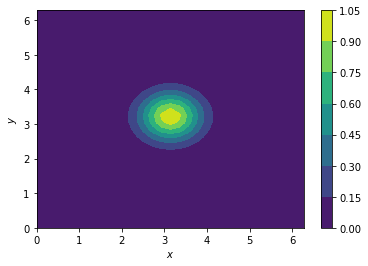

0.0 1.0102191566481273


In [12]:
Pl = pl(X, Y)
plot(X, Y, Pl)
print(np.min(Pl), np.max(Pl))

#### Numpy

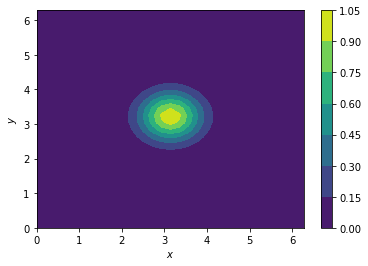

0.0 1.0102191566481271


In [13]:
plot(X, Y, P)
print(np.min(P), np.max(P))

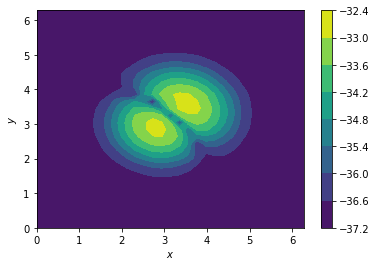

5.362461701620408e-15


In [14]:
plot(X, Y, log_abs(P, Pl))
print(error(P, Pl))

$p(x, 2\,\pi) = 0$

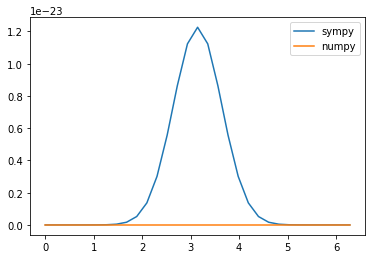

In [15]:
plt.plot(x, pl(x, 2 * np.pi), label="sympy")
plt.plot(x, p(x, 2 * np.pi), label="numpy")
#plt.plot(x, px2pi(x))
#plt.yscale('log')
plt.legend()
plt.show()

$\frac{\partial p}{\partial y} = 0$

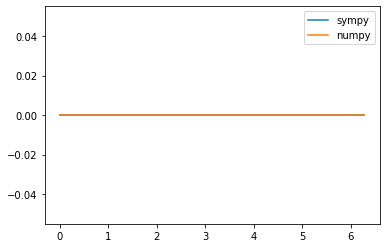

In [16]:
plt.plot(x, pyl(x, 0), label="sympy")
plt.plot(x, py(x, 0), label="numpy")
#plt.plot(x, pyx0(x))
#plt.yscale('log')
plt.legend()
plt.show()

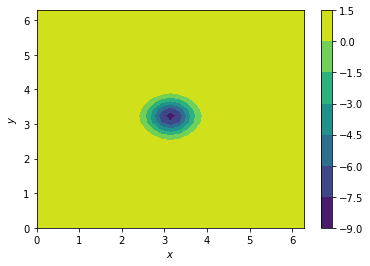

In [17]:
plot(X, Y, f(X, Y))

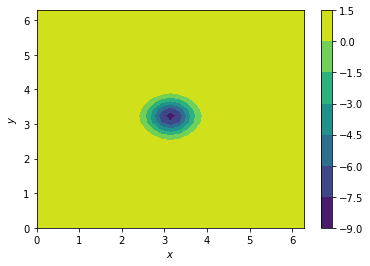

In [18]:
plot(X, Y, fl_sym(X, Y))

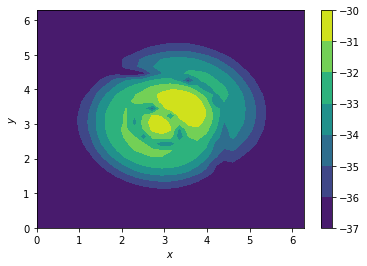

In [19]:
plot(X, Y, log_abs(f(X, Y), fl_sym(X, Y)))

### Using Finite Difference

\begin{equation}
    \frac{p_{i+1,j} - 2p_{i,j} + p_{i-1,j}}{\Delta x^2} + \frac{p_{i,j+1} - 2p_{i,j} + p_{i,j-1}}{\Delta y^2} = f_{i,j}
\end{equation}

#### Iterative

\begin{equation}
    \begin{split}
        -2\left(\frac{1}{\Delta x^2} + \frac{1}{\Delta y^2}\right)p_{i,j} &=f_{i,j} 
        - \frac{1}{\Delta x^2}\left(p_{i+1,j} + p_{i-1,j}\right) 
        - \frac{1}{\Delta y^2}\left(p_{i,j+1} + p_{i,j-1}\right) \\
        2\left(\frac{\Delta y^2 + \Delta x^2}{\Delta x^2\Delta y^2}\right)p_{i,j} &=
        \frac{1}{\Delta x^2}\left(p_{i+1,j} + p_{i-1,j}\right) +
        \frac{1}{\Delta y^2}\left(p_{i,j+1} + p_{i,j-1}\right) - f_{i,j} \\
        p_{i,j} &= \frac{1}{2\left(\Delta x^2 + \Delta y^2\right)}
            \left[
                \Delta y^2\left(p_{i+1,j} + p_{i-1,j}\right) +
                \Delta x^2\left(p_{i,j+1} + p_{i,j-1}\right) -
                \Delta x^2\Delta y^2f_{i,j}
            \right] \\
        p_{i,j}^{n+1} &= \frac{1}{2\left(\Delta x^2 + \Delta y^2\right)}
            \left[
                \Delta y^2\left(p_{i+1,j}^{n} + p_{i-1,j}^{n}\right) +
                \Delta x^2\left(p_{i,j+1}^{n} + p_{i,j-1}^{n}\right) -
                \Delta x^2\Delta y^2f_{i,j}
            \right]
    \end{split}
\end{equation}

In [20]:
P_FD = fd_solver(x, y, F, p_top, method='direct', tol=1e-12, n_iter=4000)
np.min(P_FD), np.max(P_FD)

(-0.00042025901132725416, 1.0330292745530252)

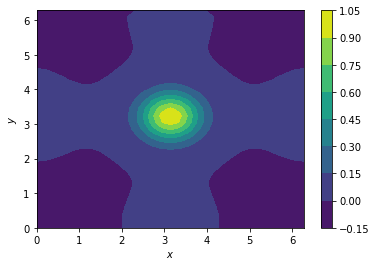

In [21]:
plot(X, Y, P_FD)

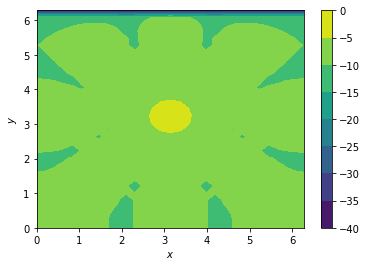

0.016645150102888827

In [22]:
plot(X, Y, log_abs(P, P_FD))
error(P, P_FD)

### Using FFT-FD

In [23]:
P_FFTFD = fftfd_solver(x, y, F, p_top)
print(np.min(P_FFTFD), np.max(P_FFTFD))

-0.00016589112208262083 1.0217321990654025


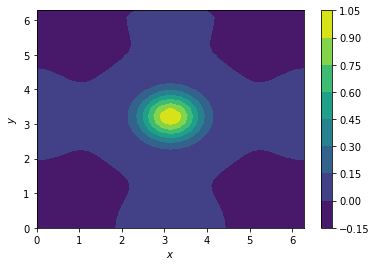

In [24]:
plot(X, Y, P_FFTFD)

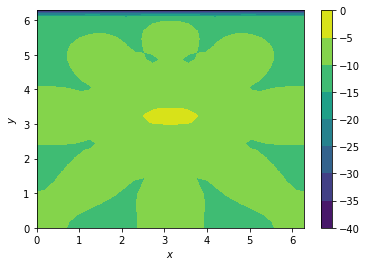

0.015085675692570745

In [25]:
plot(X, Y, log_abs(P, P_FFTFD))
error(P, P_FFTFD)

In [35]:
nn = 4
NN = np.logspace(4, 4 + nn, nn + 1, base=2, dtype=int) 
for nnn in NN:
    print("N:", nnn)
    _, __ = experiment(nnn-1, nnn, f, p, p_top, fftfd_solver)
    print()

N: 16
0.020127328147955207

N: 32
0.006012937706595467

N: 64
0.0015506370715089868

N: 128
0.00038756953063057153

N: 256
9.650448251491417e-05



In [26]:
n = 4
N = np.logspace(4, 4 + n, n + 1, base=2, dtype=int) 
error_fdc = np.zeros(N.shape[0])
error_fftfd = np.zeros(N.shape[0])
print(N)

[ 16  32  64 128 256]


In [ ]:
for i, n in enumerate(N):
    print(i, n)
    P, P_fdc = experiment(n-1, n, f, p, p_top, fd_solver)
    P, P_fftfd = experiment(n-1, n, f, p, p_top, fftfd_solver)
    error_fdc[i] = error(P, P_fdc)
    error_fftfd[i] = error(P, P_fftfd)

In [ ]:
plt.plot(N, error_fdc, 'r-x', markersize=20, label="FD")
plt.plot(N, error_fftfd, 'g-d', label="FFT-FD")
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
plt.imshow(P_fftfd, origin="lower")
plt.colorbar()
plt.show()
print(np.min(P_fftfd), np.max(P_fftfd))

---